In [18]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import sys, os
from utils.basic_utils import *
from utils.pricing import *
from utils.fundamental import *

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import forest

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.validation import column_or_1d
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

In [56]:
# environment variables
freq = '1d'
cuts = { '1d': [-1, -0.1, -.02, .02, .1, 1.] }
cut_range = cuts[freq]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

# pricing, refresh once
benchSL, sectorSL, riskSL, rateSL, bondSL, commSL, currSL = \
    config['benchmarks'], config['sectors'], config['risk'], config['rates'], \
    config['bonds'], config['commodities'], config['currencies']
symbols_list = benchSL + sectorSL + riskSL + rateSL + bondSL + commSL + currSL

keep_bench = excl(benchSL, ['^STOXX50E', '^AXJO'])
keep_fx = excl(currSL, ['HKD=X', 'MXN=X', 'AUDUSD=X', 'NZDUSD=X', 'TWD=X', 'CLP=X', 'KRW=X'])
keep_sect = excl(sectorSL, ['SPY', 'QQQ', 'DIA', 'IWM', 'XLC', 'XLRE'])
keep_bonds = ['LQD', 'HYG']

include = riskSL + keep_bench + keep_sect + rateSL + keep_fx + keep_bonds
invert = ['EURUSD=X', 'GBPUSD=X']
incl_price = riskSL

bench = '^GSPC'
y_col = 'fwdReturn'
pred_fwd_windows = [20, 60, 120]

rate_windows = [20, 60]
sec_windows, stds = [5, 20, 60], 1
ml_path = '../ML/'
vote = 'hard'

In [67]:
# utility functions
def create_ds(px_close):
    """ Create macro dataset and filtering index"""
    portion = context['portion']
    verbose = context['verbose']
    # average the return of the next periods
    # select only rows where Y variable is not null
    ds_idx = px_close.dropna(subset=[bench]).index
    Y = px_fwd_rets(px_close.loc[ds_idx, bench], bench, pred_fwd_windows).mean(axis=1)
    if verbose: print('Y.shape: ', Y.shape)
    
    df_large = pd.DataFrame()
    # rate transforms
    rate_ft_df = rate_feats(px_close[rateSL], rate_windows)
    df_large[rate_ft_df.columns] = rate_ft_df

    # price momentum transforms
    super_list = []
    for ticker in include:
        inv = ticker in invert
        incl_px = ticker in incl_price
        df = px_close[ticker]
        ft_df = px_mom_feats(df, ticker, stds, inv, incl_px, sec_windows)
        super_list.append(ft_df.drop_duplicates())
    df_large = pd.concat(super_list, axis=1).sort_index()
    df_large[y_col] = Y

    # drop NAs before discretizing
    df_large = df_large.loc[ds_idx, :]
    if verbose: print('df_large.shape: ', df_large.shape)
    
    # reduces the dataset in case is too large    
    if portion < 100e-2:
        _, df_large = train_test_split(df_large, test_size=portion, random_state=42)
    if verbose: print('create_ds >> df_large.shape: ', df_large.shape)
    
    return ds_idx, df_large

def pre_process_ds(df, context):
    
    verbose = context['verbose']
    train_model = context['train_model']
    fill_on, imputer_on, scaler_on = \
        context['fill'], context['impute'], context['scale']
    test_sz = context['test_size']
    pred_batch = context['predict_batch']

    imputer = SimpleImputer(
        missing_values=np.nan, strategy='median', copy=False)
    scaler = StandardScaler()
    X_cols = excl(df.columns, [y_col])

    df.replace([np.inf, -np.inf], np.nan, inplace=True)    
    if fill_on: df.fillna(method=fill_on, inplace=True)
    if scaler_on: df.loc[:, X_cols] = scaler.fit_transform(df[X_cols])
    
    pred_X = df.iloc[-pred_batch:,:-1].copy() # how far back to predict
    X_train = X_test = y_train = y_test = None
    
    if train_model:
        if fill_on: df[X_cols].fillna(method=fill_on, inplace=True)
        # discretize forward returns into classes
        df.dropna(subset=[y_col], inplace=True)
        df[y_col] = discret_rets(df[y_col], cut_range, fwd_ret_labels)
        df[y_col] = df[y_col].astype(str)
        # this seems unnecesary when fill is on
        if imputer_on: df.loc[:, X_cols] = imputer.fit_transform(df[X_cols])
        else: df[X_cols].dropna(inplace=True)
        X, y = df.drop(columns=y_col), df[y_col]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_sz, random_state=42)
        if verbose:
            y_col_dist = sample_wgts(df[y_col], fwd_ret_labels)
            print('pre_process_ds >> df_raw Y-var class distribution')
            print((y_col_dist[fwd_ret_labels]).round(3))
    
    return pred_X, X_train, X_test, y_train, y_test

def train_ds(context):

    print('Benchmark: {}, Y: {}, Include: {}, invert: {}, include price: {}'.format(
    bench, y_col, include, invert, incl_price))

    ml_path = context['ml_path']
    grid_search = context['grid_search']
    verbose = context['verbose']

    px_close = get_mults_pricing(include, freq, verbose=verbose);
    px_close.drop_duplicates(inplace=True)
    if verbose: print('train_ds >> px_close.shape', px_close.shape)

    # create and pre-process datasets
    px_idx, df_raw = create_ds(px_close)
    pred_X, X_train, X_test, y_train, y_test = pre_process_ds(df_raw, context)
    if verbose:
        for x in zip(('df_raw', 'pred', 'X_train', 'y_train', 'X_test', 'y_test'),
        (df_raw, pred_X, X_train, y_train, X_test, y_test)):
            print(x[0] + '.shape', x[1].shape)

    # RandomForestClassifier
    best_params = {
        'max_features': 'sqrt', 'n_estimators': 100,
        'random_state': 4}
    if grid_search:
        print('GridSearchCV for RandomForestClassifier')
        param_grid = {
            'n_estimators': [100], 'max_features': ['sqrt'],
            'random_state': np.arange(0, 5, 1),}
        clf = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid, n_jobs=-1,
                           cv=5, iid=True, verbose=verbose)
        clf.fit(X_train, y_train)
        if verbose: print_cv_results(
            clf, X_train, X_test, y_train, y_test,
            feat_imp=True, top=20)
        best_params = clf.best_params_
    clf1 = RandomForestClassifier(**best_params)
    clf1.fit(X_train, y_train)
    print('RandomForestClassifier scores: Train {}, Test {}'.format(
    clf1.score(X_train, y_train), clf1.score(X_test, y_test)))

    # MLPClassifier
    best_params = {
        'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 95,
        'learning_rate': 'adaptive', 'max_iter': 200,
        'random_state': 4, 'solver': 'lbfgs'}
    if grid_search:
        print('GridSearchCV for MLPClassifier')
        param_grid = {
            'solver': ['lbfgs'], # ['lbfgs', 'sgd', 'adam']
            'max_iter': [200], # [200, 400, 600]
            'activation': ['relu'], # ['logistic', 'tanh', 'relu']
            'alpha': 10.0 ** -np.arange(2, 5, 1), # 10.0 ** -np.arange(2, 5, 1)
            'learning_rate' : ['adaptive'], # ['constant', 'adaptive']
            'hidden_layer_sizes': np.arange(5, X_train.shape[1] // 3, int(X_train.shape[1] * 0.1)), # np.arange(5, 50, 10)
            'random_state': np.arange(0, 5, 1)} # np.arange(0, 10, 2)
        clf = GridSearchCV(MLPClassifier(random_state=42), param_grid, n_jobs=-1, cv=5,
                          iid=True, verbose=verbose)
        clf.fit(X_train, y_train)
        if verbose: print_cv_results(
            clf, X_train, X_test, y_train, y_test,
            feat_imp=False, top=20)
        best_params = clf.best_params_

    clf2 = MLPClassifier(**best_params)
    clf2.fit(X_train, y_train)
    print('MLPClassifier scores Train {}, Test {}'.format(
    clf2.score(X_train, y_train), clf2.score(X_test, y_test)))

    # ExtraTreesClassifier
    clf3 = ExtraTreesClassifier(
        n_estimators=100, max_depth=None,
        min_samples_split=2, random_state=42)
    clf3.fit(X_train, y_train)
    print('ExtraTreesClassifier scores Train {}, Test {}'.format(
    clf3.score(X_train, y_train), clf3.score(X_test, y_test)))

    for vote in ['hard', 'soft']:
        eclf = VotingClassifier(
            estimators=[('rf', clf1), ('mlp', clf2), ('et', clf3)],
            voting=vote)
        clf = eclf.fit(X_train, y_train)
        print('VotingClassifier scores Train {}, Test {}'.format(
                clf.score(X_train, y_train), clf.score(X_test, y_test)))

        os.makedirs(ml_path, exist_ok=True)
        fname = ml_path + f'macro_ML_{vote}.pkl'
        joblib.dump(clf, fname)
        print('Saved ', fname)
        
def predict_ds(context):
    ml_path = context['ml_path']
    verbose = context['verbose']
    
    px_close = get_mults_pricing(include, freq, verbose=verbose);
    px_close.drop_duplicates(inplace=True)
    
    ds_idx, df_large = create_ds(px_close)
    pred_X, _, _, _, _ = pre_process_ds(df_large, context)    

    print('pred_X.shape', pred_X.shape)

    bench_df = px_close.loc[pred_X.index, bench].to_frame()
    for vote in ['hard', 'soft']:
        fname = ml_path + f'macro_ML_{vote}.pkl'
        clf = joblib.load(fname) # load latest models
        print('Loaded', fname)
        preds = clf.predict(pred_X)
        pred_class = np.array([fwd_ret_labels.index(x) for x in preds])        
        bench_df[f'{vote}_pred_class'] = pred_class
        bench_df[f'{vote}_pred_label'] = preds
        if vote == 'soft':
            probs = clf.predict_proba(pred_X)
            pred_prob = np.argmax(probs, axis=1)
            bench_df[f'{vote}_confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
            prob_df = pd.DataFrame(probs, index=bench_df.index, columns=clf.classes_)
            bench_df = pd.concat([bench_df, prob_df[fwd_ret_labels]], axis=1)
        bench_df.dropna(subset=[bench], inplace=True)

    return bench_df

def print_cv_results(clf, X_train, X_test, y_train, y_test, full_grid=False, feat_imp=True, top=20):
    print(clf)
    cvres = clf.cv_results_
    print('BEST PARAMS:', clf.best_params_)
    print('SCORES:')
    print('clf.best_score_', clf.best_score_)
    print('train {}, test {}'.format(
        clf.score(X_train, y_train), 
        clf.score(X_test, y_test)))
    if full_grid:
        print('GRID RESULTS:')
        for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]): 
            print(round(mean_score, 3), params)
    if feat_imp:
        feature_importances = clf.best_estimator_.feature_importances_
        print('SORTED FEATURES:')
        print(sorted(zip(feature_importances, list(X_train.columns)), reverse=True)[:top])
        
def visualize_predictions(pred_df):
    pre_class_cols = filter_cols(pred_df.columns, "pred_class")
    pred_df.loc[:,[bench] + pre_class_cols].plot(
        secondary_y=pre_class_cols, figsize=(15, 5));
    pred_df[fwd_ret_labels].plot.area(
            title='Prediction Probabilities',
            figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn');
    f'Confidence Mean: {pred_df["soft_confidence"].mean().round(3)}, Median {pred_df["soft_confidence"].median().round(3)}'

def append_pricing(symbol, freq='1d', cols=None):
    """ appends most recent pricing to data on S3"""
    return appended_df

def pull_latest_px(tickers):
    """ get appended pricing from dataset """
    return px_close        

### Final version

Given the date range of key series currently working only with:
- Benchmarks: DOW, Nasdaq, SPY, and Russell 2000
- Sectors ETFs (excluding benchmarks)
- Rates: 2, 5, 10, and 30 year treasuries
- Risk: VIX
- Hard currencies (JPY, EUR, GBP and Dollar Index DXY)
- Corporate Bonds: Investment Grade (LQD), High Yield (JNK and HYG)

Ideally would like to go back further are include:
- Commodities price change
- Yields Spreads from Corporate Spreads

In [15]:
# PERSIST / READ PRICING
# px_close = get_mults_pricing(include, freq, verbose=True);
# px_close.drop_duplicates(inplace=True)
# os.makedirs('tmp', exist_ok=True)
# px_close.to_parquet('tmp/mult-macro-px-ds')
# px_close = pd.read_parquet('tmp/mult-macro-px-ds')
# px_close.dropna(subset=[bench]).shape, px_close.dropna(subset=keep_bench).shape, px_close.dropna(subset=include).shape

# PERSIST DATASET
# ds_idx, df_large = create_ds(px_close)
# os.makedirs('tmp', exist_ok=True)
# df_large.to_parquet('tmp/macro-ds-large')

# PRE-PROCESS DATASET
# train_idx, df_large = create_ds(px_close)
# pred_X, X_train, X_test, y_train, y_test = pre_process_ds(df_large, context)
# pred_X.shape
# check for NAs, there should be none
# df = X_train
# df.loc[:,df.isna().any(0).values].columns
# df.tail().isna().any(0).sort_values()

#### Train

In [63]:
context = {
    'portion': 100e-2,
    'fill': 'bfill',
    'impute': True,
    'scale': True,
    'test_size': .20,
    'predict_batch': 252,
    'ml_path': '../ML/',
    'grid_search': True,
    'verbose': 0}

In [64]:
context['train_model'] = True
%time train_ds(context)

Benchmark: ^GSPC, Y: fwdReturn, Include: ['^VIX', '^FTSE', '^GSPC', '^GDAXI', '^N225', '^DJI', '^HSI', '^IXIC', '^RUT', 'IJH', 'XLV', 'XLK', 'EEM', 'XLI', 'XLU', 'XLE', 'FXI', 'XLY', 'XLB', 'XLF', 'XLP', 'IJR', '^IRX', '^FVX', '^TNX', '^TYX', 'CHF=X', 'JPY=X', 'DX-Y.NYB', 'CNY=X', 'GBPUSD=X', 'EURUSD=X', 'LQD', 'HYG'], invert: ['EURUSD=X', 'GBPUSD=X'], include price: ['^VIX']


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


GridSearchCV for RandomForestClassifier
RandomForestClassifier scores: Train 1.0, Test 0.8896276595744681
GridSearchCV for MLPClassifier
MLPClassifier scores Train 1.0, Test 0.8670212765957447
ExtraTreesClassifier scores Train 1.0, Test 0.8936170212765957
VotingClassifier scores Train 1.0, Test 0.8936170212765957
Saved  ../ML/macro_ML_hard.pkl
VotingClassifier scores Train 1.0, Test 0.8909574468085106
Saved  ../ML/macro_ML_soft.pkl
CPU times: user 42.6 s, sys: 671 ms, total: 43.3 s
Wall time: 1min 46s


#### Predict

In [ ]:
context['train_model'] = False
%time pred_df = predict_ds(context)
pred_df.tail(5).round(3).T

In [68]:
pred_df.tail(5).round(3).T

,2019-03-18 00:00:00,2019-03-19 00:00:00,2019-03-20 00:00:00,2019-03-21 00:00:00,2019-03-22 00:00:00
^GSPC,2832.94,2832.57,2824.23,2854.88,2800.71
hard_pred_class,3,3,3,3,3
hard_pred_label,long,long,long,long,long
soft_pred_class,3,3,3,3,3
soft_pred_label,long,long,long,long,long
soft_confidence,0.677,0.7,0.74,0.703,0.783
bear,0.007,0.007,0.007,0.003,0.02
short,0.023,0.027,0.023,0.033,0.01
neutral,0.283,0.25,0.22,0.247,0.17
long,0.677,0.7,0.74,0.703,0.783


#### Store / Read S3

In [21]:
# store in S3
s3_df = pred_df.reset_index(drop=False)
rename_col(s3_df, 'index', 'pred_date')
csv_store(s3_df, 'recommend/', 'macro_risk_ML.csv')

Saved recommend/macro_risk_ML.csv


In [71]:
# read from S3
pred_df = pd.read_csv(
    csv_load('recommend/macro_risk_ML'), 
    index_col='pred_date', parse_dates=True)

#### Visualize

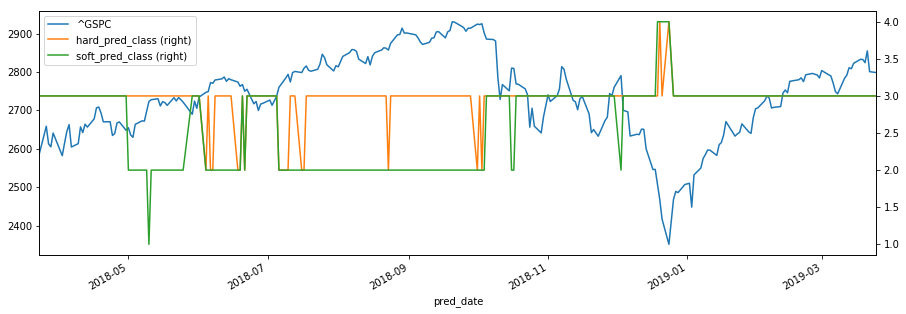

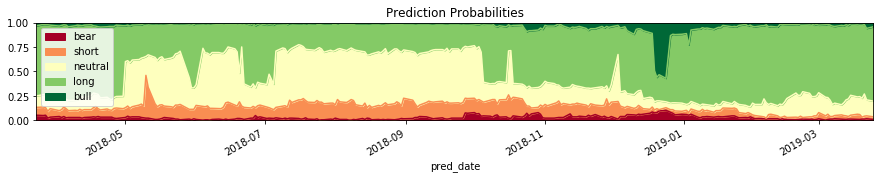

In [73]:
visualize_predictions(pred_df)

### Step by step

#### Dataset creation

(3775,)

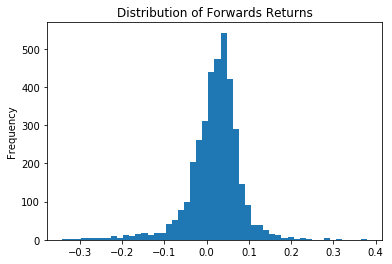

In [829]:
# average the return of the next periods
# select only rows where Y variable is not null
train_idx = px_close.dropna(subset=[bench]).index
Y = px_fwd_rets(px_close.loc[train_idx, bench], bench, pred_fwd_windows).mean(axis=1)
Y.plot.hist(bins=50, title='Distribution of Forwards Returns')
Y.shape

In [830]:
%%time
df_large = pd.DataFrame()

# rate transforms
rate_ft_df = rate_feats(px_close[rateSL], rate_windows)
df_large[rate_ft_df.columns] = rate_ft_df

# price momentum transforms
super_list = []
for ticker in include:
    inv = ticker in invert
    incl_px = True if ticker in incl_price else False
    df = px_close[ticker]
    ft_df = px_mom_feats(df, ticker, stds, inv, incl_px, sec_windows)
    super_list.append(ft_df.drop_duplicates())
df_large = pd.concat(super_list, axis=1).sort_index()

df_large[y_col] = Y

# drop NAs before discretizing
df_large = df_large.loc[train_idx, :]

print(df_large.shape)

(3775, 308)
CPU times: user 699 ms, sys: 47.6 ms, total: 746 ms
Wall time: 650 ms


/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [831]:
os.makedirs('tmp', exist_ok=True)
df_large.to_parquet('tmp/macro-ds-large')

#### Pre-processing

In [832]:
df_large = pd.read_parquet('tmp/macro-ds-large')
df_large.shape

(3775, 308)

In [833]:
# Trims dataset in case it's too large for experimentation
# Reduce dataset for experimentation
# Note that experiment dataset is not stratified
_, df_raw = train_test_split(df_large, test_size=100e-2, shuffle=False, )
df_raw.shape

(3775, 308)

In [834]:
# keeps a chunk of the pre-processed dataset for predictions later
# take everything but Y var
look_back = 252*3
recent_X = df_large.iloc[-look_back:,:-1].copy()
print(recent_X.shape)

(756, 307)


In [835]:
# discretize returns into classes
df_raw.dropna(subset=[y_col], inplace=True)
df_raw.loc[:, y_col] = discret_rets(df_raw[y_col], cut_range, fwd_ret_labels)

y_col_dist = sample_wgts(df_raw[y_col], fwd_ret_labels)
(y_col_dist[fwd_ret_labels]).round(3)

bear       0.039
short      0.145
neutral    0.259
long       0.507
bull       0.049
Name: fwdReturn, dtype: float64

In [836]:
# how many empty values?
# (df_raw.isna().sum() / df_raw.count()).sort_values(ascending=False)

In [837]:
df_raw.fillna(method='ffill', inplace=True)

In [838]:
# Mean based imputer
imputer_on, scaler_on = True, True
imputer = SimpleImputer(missing_values=np.nan, strategy='median', copy=False)
scaler = StandardScaler()

df_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

pre_ml_df = df_raw.copy()
pre_ml_df.dropna(subset=[y_col], inplace=True)
pre_ml_df.loc[:, y_col] = pre_ml_df[y_col].astype(str)

X_cols = excl(pre_ml_df.columns, [y_col])

if imputer_on: pre_ml_df.loc[:, X_cols] = imputer.fit_transform(pre_ml_df[X_cols])
else: pre_ml_df.dropna(inplace=True)
if scaler_on: pre_ml_df.loc[:, X_cols] = scaler.fit_transform(pre_ml_df[X_cols])

X, y = pre_ml_df.drop(columns=y_col), pre_ml_df[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3004, 307), (751, 307), (3004,), (751,))

#### Train models

In [918]:
# RandomForestClassifier
# best params from GridSearch
rfc_params = {
    'max_features': 40, 'n_estimators': 100, 'random_state': 7}

clf1 = RandomForestClassifier(**rfc_params, warm_start=True)

clf1.fit(X_train, y_train)
scores = clf1.score(X_train, y_train), clf1.score(X_test, y_test)
scores

(1.0, 0.9041278295605859)

In [921]:
# MLPClassifier
# best params from GridSearch
mlp_params = {
    'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 65, 
    'learning_rate': 'adaptive', 'max_iter': 200, 
    'random_state': 3, 'solver': 'lbfgs'}

clf2 = MLPClassifier(**mlp_params, warm_start=True)

clf2.fit(X_train, y_train)
scores = clf2.score(X_train, y_train), clf2.score(X_test, y_test)
scores

(1.0, 0.8615179760319573)

In [922]:
# ExtraTreesClassifier
clf3 = ExtraTreesClassifier(
    n_estimators=100, max_depth=None, 
    min_samples_split=2, random_state=0, warm_start=True)

clf3.fit(X_train, y_train)
scores = clf3.score(X_train, y_train), clf3.score(X_test, y_test)
scores

(1.0, 0.9134487350199734)

In [910]:
%%time

eclf = VotingClassifier(
    estimators=[('rf', clf1), ('mlp', clf2), ('et', clf3)], 
    voting=vote)

clf = eclf.fit(X_train, y_train)
scores = clf.score(X_train, y_train), clf.score(X_test, y_test)

print(scores)

(1.0, 0.9134487350199734)
CPU times: user 12.1 s, sys: 28.5 ms, total: 12.2 s
Wall time: 7.57 s


In [898]:
os.makedirs(ml_path, exist_ok=True)
fname = ml_path + f'macro_ML_{vote}.pkl'
joblib.dump(clf, fname)
f'Saved {fname}'    

'Saved ../ML/macro_ML_hard.pkl'

In [899]:
clf = joblib.load(fname)
print('Loaded', fname)

Loaded ../ML/macro_ML_hard.pkl


In [900]:
# predict historically including recent dates
if imputer_on: recent_X.loc[:, X_cols] = imputer.fit_transform(recent_X[X_cols])
else: recent_X.dropna(inplace=True)
if scaler_on: recent_X.loc[:, X_cols] = scaler.fit_transform(recent_X[X_cols])

In [907]:
assert recent_X.shape[1] == X_train.shape[1]

In [902]:
assert recent_X.shape[1] == X_train.shape[1]
preds = clf.predict(recent_X)
assert recent_X.shape[0] == preds.shape[0]

pred_class = np.array([fwd_ret_labels.index(x) for x in preds])

SPY = px_close.loc[recent_X.index, bench].to_frame()
SPY['pred_class'] = pred_class
SPY['pred_label'] = preds

if vote == 'soft':
    probs = clf.predict_proba(recent_X)
    pred_prob = np.argmax(probs, axis=1)
    SPY.loc[:, 'high_prob'] = [x[np.argmax(x)] for x in probs] # higest prob
    SPY.loc[:, 'pred_prob'] = probs[range(pred_class.shape[0]), pred_class] # predict class prob

SPY.dropna(subset=[bench], inplace=True)    

In [903]:
# why are predict classes and prob distribution do not math?
# preds, pred_class, probs[-10:]
# df = pd.DataFrame()
# df['pred_class'] = pred_class
# df['pred_prob'] = probs[range(pred_class.shape[0]), pred_class]
# df.plot(secondary_y='pred_prob')

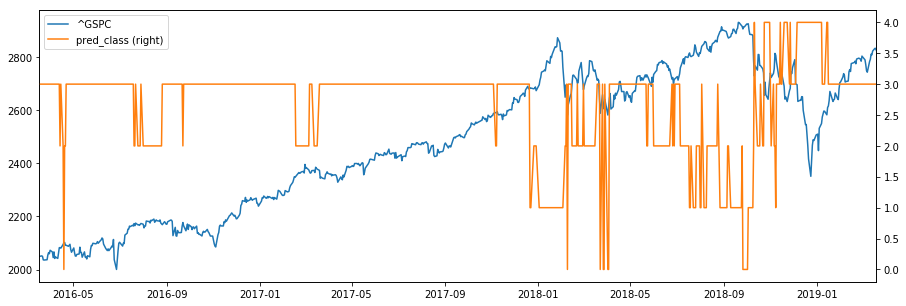

In [904]:
# plot predictions
SPY['pred_class'] = pred_class
SPY['pred_label'] = preds
SPY.loc[:,[bench, 'pred_class']].plot(secondary_y='pred_class', figsize=(15, 5));

if vote == 'soft':
    SPY[['high_prob']].plot(
        title='Historical predictions',
        figsize=(15, 2), ylim=(0, 1),);
    SPY[['pred_prob']].plot(
        title='Probability of highest & predicted class',
        figsize=(15, 2), ylim=(0, 1),);
    
    prob_df = pd.DataFrame(probs, columns=fwd_ret_labels, index=recent_X.index)
    prob_df.plot(
        title='Class probabilities',
        figsize=(15, 8), subplots=True, ylim=(0,1));    

In [905]:
if vote == 'soft':
    SPY[['high_prob', 'pred_prob']].plot.hist(
        bins=50, xlim=(0,1), title='Confidence Distribution')
    print('Probability for predicted class: Mean %.f, median %.f, ' % (
        SPY.pred_prob.mean() * 100,
        SPY.pred_prob.median() * 100))
    print('Probability for highest class: Mean %.f, median %.f, ' % (
        SPY.high_prob.mean() * 100,
        SPY.high_prob.median() * 100))

In [906]:
SPY.tail(10)

,^GSPC,pred_class,pred_label
2019-03-07,2748.929932,3,long
2019-03-08,2743.070068,3,long
2019-03-11,2783.300049,3,long
2019-03-12,2791.520020,3,long
2019-03-13,2810.919922,3,long
2019-03-14,2808.479980,3,long
2019-03-15,2822.479980,3,long
2019-03-18,2832.939941,3,long
2019-03-19,2832.570068,3,long
2019-03-20,2824.229980,3,long


#### Metrics

In [ ]:
draw_tree(clf1.estimators_[0], X, precision=3)

Feature ranking:
287 feature CNY=XPct52WkH (0.024849377783455893)
144 feature XLEPct52WkL (0.013218939050392871)
282 feature CNY=XPctMA200 (0.012404515423505558)
197 feature XLYPct52WkH (0.011912909069549296)
243 feature ^TNXPct52WkL (0.01126378006401266)
62 feature ^IXICPct52WkH (0.011133574604577283)
306 feature DX-Y.NYBPct52WkL (0.010157533129669454)
54 feature ^HSIPct52WkL (0.009694007594760395)
315 feature LQDPct52WkL (0.00953296071587264)
66 feature ^GDAXIPctMA200 (0.00947710950447375)
260 feature CHF=XPct52WkH (0.0091177288915707)
171 feature EEMPct52WkL (0.008740562722326936)
153 feature IJHPct52WkL (0.008597192336110497)
189 feature XLFPct52WkL (0.00855783763385855)
17 feature ^AXJOPct52WkH (0.008463215340582747)
261 feature CHF=XPct52WkL (0.008431946481305795)
207 feature XLBPct52WkL (0.008131257313017766)
135 feature FXIPct52WkL (0.008060698182734513)
220 feature ^IRXRollVol30 (0.007995710675251783)
89 feature ^N225Pct52WkH (0.007777820554561221)
198 feature XLYPct52WkL (0.0

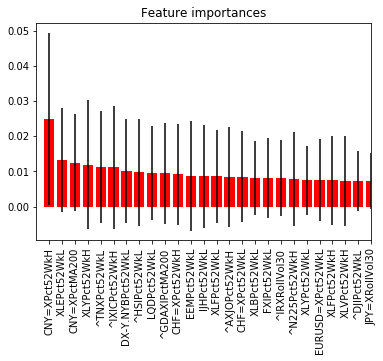

In [713]:
show_fi(clf1, X, 25)

In [338]:
log_loss(y_test, clf1.predict_proba(X_test))

0.29202775313352175

In [339]:
print('Confussion Matrix\n', confusion_matrix(clf.predict(X_test), y_test, labels=fwd_ret_labels))

Confussion Matrix
 [[ 28   0   0   0   0]
 [  3  81   7   0   0]
 [  0  14 180  17   0]
 [  0   0  13 366   9]
 [  0   0   1   1  31]]


In [340]:
print('Classificaton report\n', classification_report(clf.predict(X_test), y_test, target_names=fwd_ret_labels))

Classificaton report
               precision    recall  f1-score   support

        bear       0.90      1.00      0.95        28
       short       0.78      0.94      0.85        33
     neutral       0.95      0.94      0.95       388
        long       0.90      0.85      0.87       211
        bull       0.85      0.89      0.87        91

   micro avg       0.91      0.91      0.91       751
   macro avg       0.88      0.93      0.90       751
weighted avg       0.92      0.91      0.91       751



In [341]:
fi = rf_feat_importance(clf1, pd.DataFrame(X)); fi[:10]

,cols,imp
269,CNY=XPct52WkH,0.031194
48,^GDAXIPctMA200,0.015366
243,CHF=XPct52WkL,0.014367
264,CNY=XPctMA200,0.012686
126,XLEPct52WkL,0.012149
179,XLYPct52WkH,0.011880
44,^IXICPct52WkH,0.010744
242,CHF=XPct52WkH,0.010714
297,LQDPct52WkL,0.010321
288,DX-Y.NYBPct52WkL,0.009807


In [342]:
clf1.predict_proba(X_test)

array([[0.  , 0.  , 0.32, 0.68, 0.  ],
       [0.82, 0.  , 0.09, 0.05, 0.04],
       [0.  , 0.  , 0.98, 0.02, 0.  ],
       ...,
       [0.  , 0.  , 0.97, 0.02, 0.01],
       [0.  , 0.  , 0.51, 0.46, 0.03],
       [0.  , 0.  , 0.08, 0.66, 0.26]])

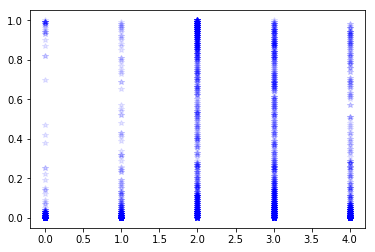

In [343]:
[plt.plot(x.tolist(), alpha=0.1, color='b', marker='*', linewidth=0) for x in clf1.predict_proba(X_test)];

#### Gridsearches

In [ ]:
%%time
# GridSearchCV for RandomForestClassifier
verbose = True
parameters = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'random_state': np.arange(0, 5, 1),}
clf = GridSearchCV(RandomForestClassifier(), 
                   parameters, n_jobs=-1, 
                   cv=5, iid=True, verbose=5)
clf.fit(X_train, y_train)
if verbose: print_cv_results(
    clf, X_train, X_test, y_train, y_test, 
    feat_imp=True, top=20)

In [ ]:
%%time
# GridSearchCV for MLPClassifier
parameters = {
    'solver': ['lbfgs'], # ['lbfgs', 'sgd', 'adam']
    'max_iter': [200], # [200, 400, 600]
    'activation': ['relu'], # ['logistic', 'tanh', 'relu']
    'alpha': 10.0 ** -np.arange(2, 5, 1), # 10.0 ** -np.arange(2, 5, 1)
    'learning_rate' : ['adaptive'], # ['constant', 'adaptive']
    'hidden_layer_sizes': np.arange(5, X_train.shape[1] // 3, int(X_train.shape[1] * 0.1)), # np.arange(5, 50, 10)
    'random_state': np.arange(0, 5, 1)} # np.arange(0, 10, 2)
clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1, cv=5,
                  iid=True, verbose=5)
clf.fit(X_train, y_train)
if verbose: print_grid_search(
    clf, X_train, y_train, X_test, y_test, 
    feat_imp=False, top=20)

### Old

#### Feature construction

In [361]:
# FX
FX = ['EURUSD=X', 'JPY=X', 'GBPUSD=X', 'CNY=X', 'CHF=X', 'DX-Y.NYB']
invert = ['EURUSD=X', 'GBPUSD=X']
df_raw = px_close[FX]
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
EURUSD=X,2007.0,1.256375,0.119263,1.039047,1.137372,1.275705,1.354215,1.512791
JPY=X,2007.0,99.938852,13.995510,75.930000,87.639999,101.800003,111.478500,125.070000
GBPUSD=X,2008.0,1.500683,0.133045,1.215732,1.395727,1.544855,1.604351,1.716090
CNY=X,2006.0,6.491555,0.270240,6.031200,6.235600,6.469500,6.787900,6.974700
CHF=X,2004.0,0.968201,0.063114,0.722800,0.928380,0.966250,0.996880,1.186800
DX-Y.NYB,1971.0,86.769783,8.238749,72.930000,79.949997,83.199997,95.094997,103.290001


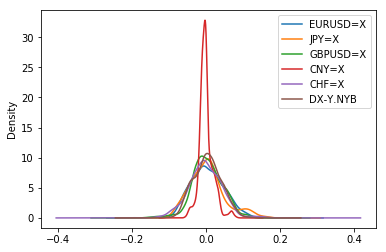

In [366]:
fx_df = df_raw.copy()
fx_df[invert] = (1 / df_raw[invert])
fx_df.tail(252)
fx_chg_df = fx_df.pct_change().rolling(60).sum()
fx_chg_df.plot.kde()

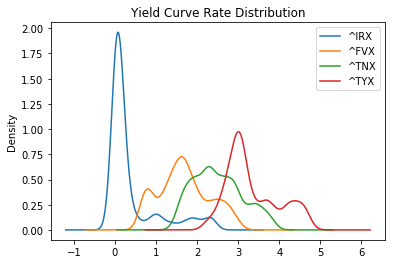

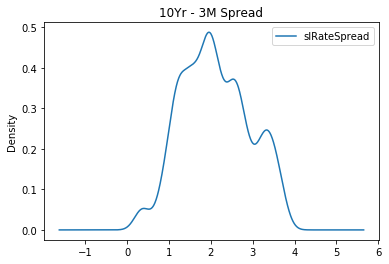

In [367]:
rates = px_close[rateSL]
rates.plot.kde(alpha=1, title='Yield Curve Rate Distribution')
rate_feats(rates, [60]).plot.kde(title='10Yr - 3M Spread')

CPU times: user 803 ms, sys: 134 ms, total: 937 ms
Wall time: 2.89 s


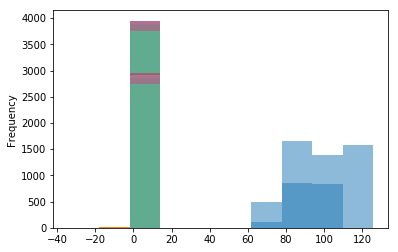

In [621]:
%%time
# Uses px_mom_feats for FX transforms
FX = ['EURUSD=X', 'JPY=X', 'GBPUSD=X', 'CNY=X', 'CHF=X', 'DX-Y.NYB']
invert = ['EURUSD=X', 'GBPUSD=X']

ndf = pd.DataFrame() 
for fx in FX:
    inv = True if fx in invert else False
    df = get_symbol_pricing(fx)
    ft_df = px_mom_feats(df, fx, 1, inv, True)
    ndf[ft_df.columns] = ft_df
ndf.plot.hist(alpha=0.5, legend=False)

Index(['^VIXClose', '^VIXPctChg2Stds', '^VIXPctMA50', '^VIXPctMA200',
       '^VIXRollVol20', '^VIXPctChg20', '^VIXPct52WkH', '^VIXPct52WkL'],
      dtype='object')


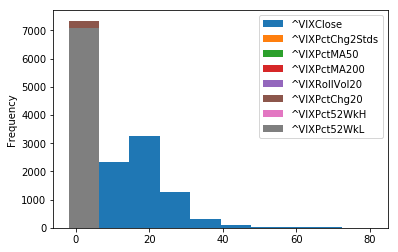

In [644]:
ft_df = px_mom_feats(get_symbol_pricing('^VIX'), '^VIX', 2, False, True, [20])
print(ft_df.columns)
ft_df.iloc[:,:].plot.hist()

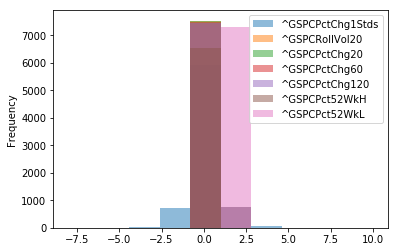

In [515]:
symbol = '^GSPC'
px_df = get_symbol_pricing(symbol)

ft_df = px_mom_feats(px_df, symbol)
# ft_df.plot(subplots=True, figsize=(10,15));
ft_df.plot.hist(alpha=0.5);

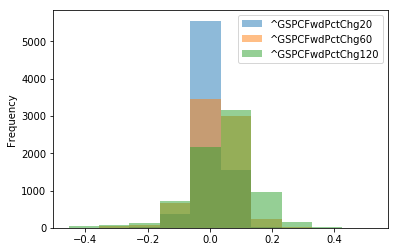

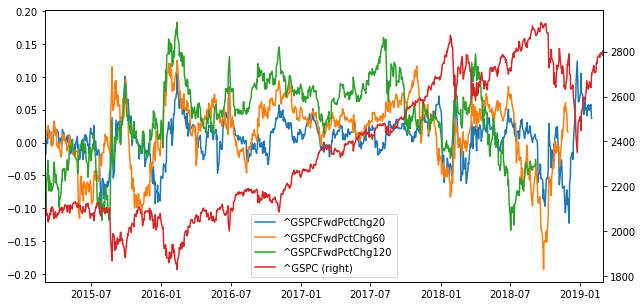

In [516]:
ft_df = px_fwd_rets(px_df, symbol)
ft_df.plot.hist(alpha=0.5);
ft_df[symbol] = px_df['close']
ft_df.tail(252*4).plot(secondary_y=symbol, figsize=(10,5));

CPU times: user 316 ms, sys: 25.4 ms, total: 341 ms
Wall time: 3.71 s


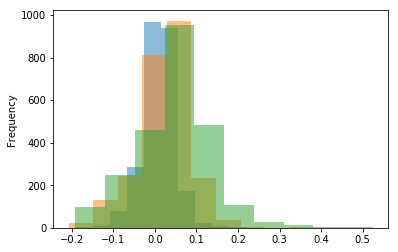

In [22]:
%%time
# average different time frames of fwd rets for all benchmarks
# do we try to estimate the average of all benchmarks or just one?
# do we try to estimate three type of fwd rets [20, 60, 120] or just one?

# calculate forward returns for all bechmarks
fwd_rets_df = pd.DataFrame()
for s in benchSL:
    px_df = get_symbol_pricing(s)
    fwd_ret = px_fwd_rets(px_df, s)
    fwd_rets_df[fwd_ret.columns] = fwd_ret
fwd_rets_df.tail()

[fwd_rets_df[[x for x in fwd_rets_df.columns if y in x]].mean(axis=1).plot.hist(alpha=0.5)
     for y in ['g20', 'g60', 'g120']]

#### Visualizations

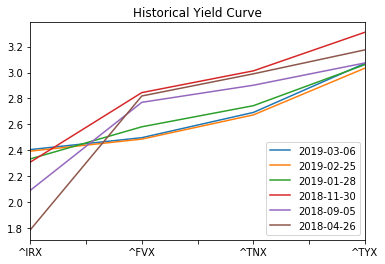

In [275]:
locs = [-int(x**3) for x in range(1, 7, 1)]
px_close[rateSL].iloc[locs, :].T.plot(title='Historical Yield Curve');
#f'Yield curve for the last {locs} days'

In [ ]:
# show correlations with Y variables
show = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
ml_ds_df.corr()[show]

In [ ]:
# series distributions
%time ml_ds_df.hist(figsize=(15,15));

In [ ]:
# scatter plots
%time pd.plotting.scatter_matrix(ml_ds_df, alpha=0.1, figsize=(40, 40));

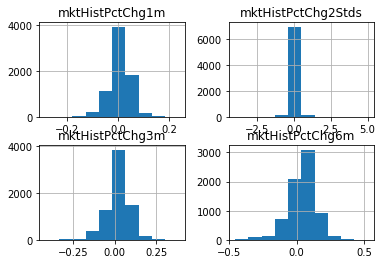

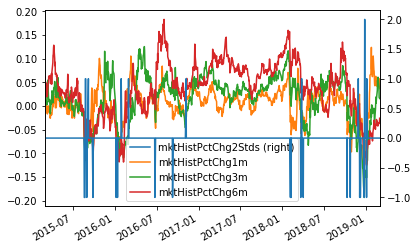

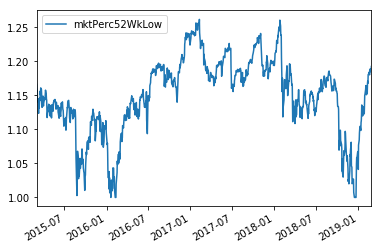

In [14]:
# historical returns for 1, 3, and 6 months
secpx['mktHistPctChgStds'] = SPY_pct_chg.apply(sign_compare, args=(SPY_pct_chg.std(),))
secpx['mktHistPctChg1m'] = SPY_close.pct_change(periods=20)
secpx['mktHistPctChg3m'] = SPY_close.pct_change(periods=60)
secpx['mktHistPctChg6m'] = SPY_close.pct_change(periods=120)
secpx['mktPerc52WkHigh'] = (SPY_close / SPY_close.rolling(252).max())
secpx['mktPerc52WkLow'] = (SPY_close / SPY_close.rolling(252).min())

show = ['mktHistPctChgStds', 'mktHistPctChg1m', 'mktHistPctChg3m', 
        'mktHistPctChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot(secondary_y='mktHistPctChgStds');
show = ['mktPerc52WkLow']
secpx[show].tail(252*4).plot();

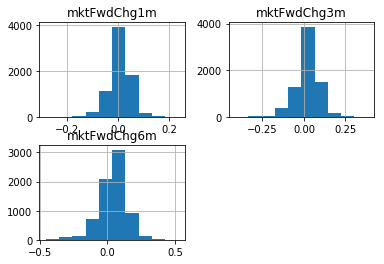

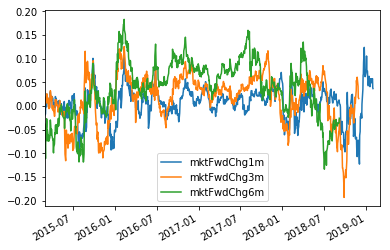

In [15]:
# Forward returns, 1w, 1m, 3m
SPY_close.pct_change(5).shift(-5)
secpx['mktFwdChg1m'] = SPY_close.pct_change(20).shift(-20)
secpx['mktFwdChg3m'] = SPY_close.pct_change(60).shift(-60)
secpx['mktFwdChg6m'] = SPY_close.pct_change(120).shift(-120)

show = ['mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot();

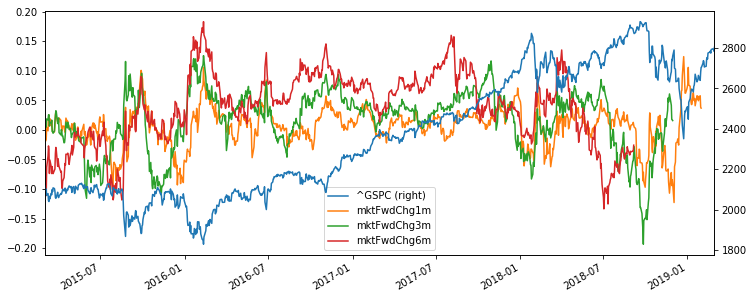

In [16]:
show = [bench_symbol, 'mktFwdChg1m', 'mktFwdChg3m', 'mktFwdChg6m']
secpx[show].tail(252*4).plot(secondary_y=bench_symbol, figsize=(12,5));

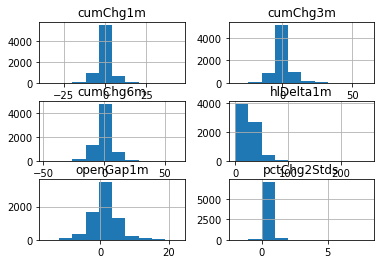

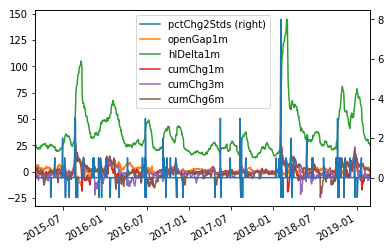

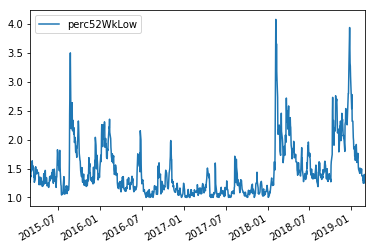

In [17]:
# cumulative deltas and gap analysis
secpx['pctChgStds'] = pct_chg.apply(sign_compare, args=(pct_chg.std(),))
secpx['openGap1m'] = (openpx - closepx.shift(1)).rolling(20).sum()
secpx['hlDelta1m'] = (highpx - lowpx).rolling(20).sum()
secpx['cumChg1m'] = (closepx - closepx.shift(1)).rolling(20).sum()
secpx['cumChg3m'] = (closepx - closepx.shift(1)).rolling(60).sum()
secpx['cumChg6m'] = (closepx - closepx.shift(1)).rolling(120).sum()
secpx['perc52WkLow'] = (closepx / closepx.rolling(252).min())

show = ['pctChgStds', 'openGap1m', 'hlDelta1m', 
        'cumChg1m', 'cumChg3m', 'cumChg6m']
secpx[show].hist();
secpx[show].tail(252*4).plot(secondary_y='pctChgStds');
show = ['perc52WkLow']
secpx[show].tail(252*4).plot();

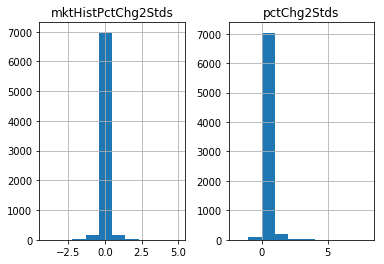

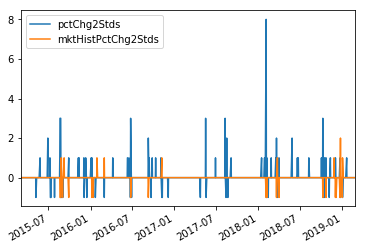

In [18]:
show = ['pctChgStds', 'mktHistPctChgStds']
secpx[show].hist();
secpx[show].tail(252*4).plot();

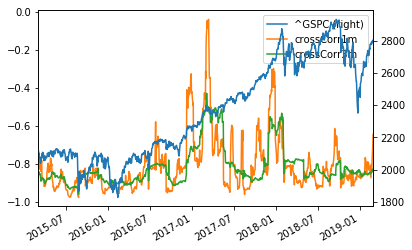

In [19]:
# rolling SPY correlations
secpx['crossCorr1m'] = closepx.pct_change().rolling(20).corr(SPY_pct_chg)
secpx['crossCorr3m'] = closepx.pct_change().rolling(60).corr(SPY_pct_chg)

show = [bench_symbol, 'crossCorr1m', 'crossCorr3m']
secpx[show].tail(252*4).plot(secondary_y=bench_symbol);
# closepx.pct_change().corr(SPY_pct_chg)

#### Missing values

In [870]:
# px_close.loc[pred_X.index, keep_bench].tail(20)
# pred_X.tail()

In [871]:
# pred_X.fillna(method='ffill', inplace=True)
# na = pred_X.tail(120).isna().any(0)
# pred_X[na[na.values].index]

#### Fixing timeseries concatenation

In [ ]:
super_list = []
for n, t in enumerate(keep_sect):
    try:
        df = get_symbol_pricing(t, freq, cols=None)
        rename_col(df, 'close', t)
        print("Retrieving pricing: {0}, {1}".format(t, df.shape))
        df.index = df.index.strftime('%Y-%m-%d')
        super_list.append(df[t])
    except Exception as e:
        print("Exception, get_mults_pricing: {0}\n{1}".format(t, e))

In [ ]:
full_df = pd.DataFrame(super_list[0])
if len(super_list[1:]):
    for x in super_list[1:]: full_df = pd.merge(full_df, x, left_index=True, right_index=True, how='outer')
full_df.index = pd.to_datetime(full_df.index)

In [ ]:
full_df.tail(20)

In [640]:
super_list[0].tail(10)

2019-02-22    1.00086
2019-02-25    0.99970
2019-02-26    1.00009
2019-03-01    0.99726
2019-03-07    1.00410
2019-03-08    1.01070
2019-03-12    1.01024
2019-03-14    1.00329
2019-03-15    1.00345
2019-03-19    1.00100
Name: CHF=X, dtype: float64

In [641]:
super_list[1].tail(10)

2019-03-07    1.131401
2019-03-08    1.119833
2019-03-11    1.123242
2019-03-12    1.125923
2019-03-13    1.128745
2019-03-14    1.133106
2019-03-15    1.130838
2019-03-18    1.131977
2019-03-19    1.133620
2019-03-21    1.142792
Name: EURUSD=X, dtype: float64

In [642]:
super_list[2].tail(10)

2019-03-06    111.865997
2019-03-07    111.623001
2019-03-08    111.634003
2019-03-11    111.080002
2019-03-12    111.342003
2019-03-13    111.306000
2019-03-14    111.195999
2019-03-15    111.752998
2019-03-18    111.560997
2019-03-19    111.373001
Name: JPY=X, dtype: float64

In [643]:
get_symbol_pricing('JPY=X')

,high,low,open,close,volume
2004-03-22,107.639999,106.699997,106.910004,106.760002,0.0
2004-03-23,106.940002,106.470001,106.739998,106.760002,0.0
2004-03-24,106.910004,106.029999,106.720001,106.400002,0.0
2004-03-25,106.419998,105.760002,106.419998,106.129997,0.0
2004-03-26,106.190002,105.540001,106.129997,106.180000,0.0
2004-03-28,105.910004,105.269997,105.269997,105.459999,0.0
2004-03-29,106.160004,105.419998,105.459999,105.839996,0.0
2004-03-30,105.889999,103.540001,105.830002,104.209999,0.0
2004-03-31,104.449997,103.300003,104.199997,103.739998,0.0
2004-04-01,104.669998,103.680000,103.720001,104.610001,0.0


In [ ]:
full_df.tail(30).sort_index()

In [ ]:
for d in super_list:
    print(d.shape, d.drop_duplicates().shape)

In [ ]:
super_list[1].duplicated().sort_values()

In [609]:
df = pd.concat(super_list, axis=1)

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [ ]:
super_list[0].tail(10).index, \
super_list[1].tail(10).index, \
super_list[2].tail(10).index, \
super_list[3].tail(10).index

In [603]:
ss = get_symbol_pricing('DX-Y.NYB', freq).tail(20)

In [ ]:
ss.index.strftime('%Y-%m-%d')

In [ ]:
# pd.merge(super_list[1], super_list[2], left_index=True, right_index=True)
# pd.concat(super_list, axis=1)
init_df = pd.DataFrame(super_list[0])
for x in super_list[1:]:
    init_df = pd.merge(init_df, x, left_index=True, right_index=True)
init_df.tail(60)

In [ ]:
pd.concat(super_list, axis=1, ).tail(15)

In [ ]:
for d in super_list: d.drop_duplicates(inplace=True)

In [ ]:
df = pd.concat(super_list, axis=1, copy=False)